# Classification and analyzis of Dutch train stations

##  Introduction

The Netherlands have an extensive rail network with many stations.

The last years more and more businesses and population are concentrating around stations. Also stations are extended with shops, horeca and office facilities to make them more attractive.

Stations are very different: 
* Major hubs in big cities with many perons and many passengers. 
* Local stations in the country side close to a small town in the middle of the fields.

Dutch railnetwerk in 2018:

<img src="./spoorkaart-2018.jpg" alt="drawing" width="500"/>

## Business Problem 

The question is what are good candidate stations to invest in facilities, like shops or horeca facilities.<br/>
The anwser to this question helps an business invester to make the right investement decisions.<br/>
The goal is analyse and cluster the trainstations in the Netherlands based on the characteristic of the stations and thier neighborhood.

## Data

The required data is:
1. the Dutch train stations and their coordinates
2. the facilities at and around these train stations

The data for point 1) is available at the NS API https://www.ns.nl/en/travel-information/ns-api. The NS is the major Dutch train operator. The API provides an Station section with endpoints to:
* get a list and coordinates of the trainstations
* get details per station.

Regarding point 2) this information is available via the FourSquare API. Via this API we retrieve the facilities very close to the station. Secondly also we retrieve the facilities in the stations neighorhoud, e.g. like horeca and museums. The stations details endpoint of the NS API will also provide details for each station.

In the Foursquare we explore the venues for the following sub-categories:
* Arts & Entertainment (4d4b7104d754a06370d81259)
* College & University (4d4b7105d754a06372d81259)
* Food (4d4b7105d754a06374d81259)
* Nightlife Spot (4d4b7105d754a06376d81259)
* Outdoors & Recreation (4d4b7105d754a06377d81259)
* Professional & Other Places (4d4b7105d754a06375d81259)
* Shop & Service (4d4b7105d754a06378d81259)
* Travel & Transport (4d4b7105d754a06379d81259)

We’ll be querying the number of venues in each category in a 1000m radius around each train station. 1000m is a reasonable walking distance.

Example station data:

In [1]:
import http, urllib, base64, http.client, urllib.request, urllib.parse, urllib.error, base64
import pandas as pd
import numpy as np
import json
import requests
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
import requests

from xml.etree import ElementTree
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize #package for flattening json in pandas df

In [2]:
geolocator = Nominatim(user_agent="nl_locator")

In [3]:
secrets = json.load(open('secrets.json'))

FOURSQUARE_CLIENT_ID = secrets['foursquare']['client_id']
FOURSQUARE_CLIENT_SECRET = secrets['foursquare']['client_secret']
FOURSQUARE_VERSION = secrets['foursquare']['version']
NS_API_PRIM_KEY = secrets['ns-api']['prim-key']
NS_API_SEC_KEY = secrets['ns-api']['sec-key']

### Retrieve the stations data

In [4]:
headers = {
    # Request headers
    'Accept-Language': '',
    'Ocp-Apim-Subscription-Key': NS_API_PRIM_KEY,
}
params = urllib.parse.urlencode({})

try:
    conn = http.client.HTTPSConnection('gateway.apiportal.ns.nl')
    conn.request("GET", "/ns-international-station-api/nearby?lat={lat}&lon={lon}&k={k}&%s" % params, "{body}", headers)
    response = conn.getresponse()
    data = response.read()
#     print('data1: {}'.format(data))
#     print('data2: {}'.format(str(data)))
    conn.close()
except Exception as e:
    print("[Errno {0}] {1}".format(e.errno, e.strerror))                    

In [5]:
ns_headers = {
    'Accept-Encoding': '',
    'Ocp-Apim-Subscription-Key': NS_API_PRIM_KEY,
}
ns_station_url = 'https://gateway.apiportal.ns.nl/ns-international-station-api'

In [6]:
import requests
r = requests.get(url=ns_station_url, headers=ns_headers)
stations = r.json()
stations_df = pd.DataFrame(stations)
nl_stations_df = stations_df[stations_df['beneCode'].str.startswith('NL')].reset_index()

location_df = json_normalize(nl_stations_df['location'])
nl_stations_df['coordinates'] = location_df['coordinates']
# nl_stations_df = nl_stations_df[~nl_stations_df['coordinates'].str.contains('None')]
# nl_stations_df.head(30)
# nl_stations_df['coordinates']=="[None,None]"
#location_df = json_normalize(nl_stations_df['coordinates'])
# nl_stations_df.dtypes
# nl_stations_df
# location_df
nl_stations_df = nl_stations_df[~nl_stations_df['coordinates'].astype(str).str.contains("None")].reset_index()
nl_stations_df.drop_duplicates(subset = 'beneCode', keep = False, inplace = True) 
nl_stations_df.head(16)

,level_0,index,aliases,beneCode,location,name,type,coordinates
0,0,0,[],NLAAC,"{'type': 'Point', 'coordinates': [4.838111, 52...",Amsterdam Sloterdijk,station,"[4.838111, 52.389025]"
1,1,1,[],NLAAF,"{'type': 'Point', 'coordinates': [4.833913, 52...",Amsterdam Lelylaan,station,"[4.833913, 52.357886]"
2,2,2,[],NLABK,"{'type': 'Point', 'coordinates': [4.917593, 52...",Amsterdam Amstel,station,"[4.917593, 52.346443]"
3,3,3,[],NLACD,"{'type': 'Point', 'coordinates': [4.976994, 52...",Abcoude,station,"[4.976994, 52.278673]"
4,4,4,[],NLADR,"{'type': 'Point', 'coordinates': [6.6664, 52.3...",Almelo de Riet,station,"[6.6664, 52.342218]"
5,5,5,[],NLAHM,"{'type': 'Point', 'coordinates': [5.901004, 51...",Arnhem Centraal,station,"[5.901004, 51.98478]"
6,6,6,[],NLAHO,"{'type': 'Point', 'coordinates': [4.960031, 52...",Amsterdam Holendrecht,station,"[4.960031, 52.298108]"
7,7,7,[],NLAHP,"{'type': 'Point', 'coordinates': [5.943317, 51...",Arnhem Presikhaaf,station,"[5.943317, 51.98789]"
8,8,8,[],NLAHV,"{'type': 'Point', 'coordinates': [5.919837, 51...",Arnhem Velperpoort,station,"[5.919837, 51.985175]"
9,9,9,[],NLAHZ,"{'type': 'Point', 'coordinates': [5.851923, 51...",Arnhem Zuid,station,"[5.851923, 51.954837]"


In [7]:
nl_stations_df.shape

(384, 8)

In [8]:
def get_postcode_per_location(coordinate):
    coords = coordinate.split(",")
    lon = coords[0]
    lat = coords[1]
    
    location = geolocator.reverse("{}, {}".format(lat,lon))
    # print("{} -> {}".format(coordinate, location.address))
    locations = location.address.split(",")
    
    return {
        'Lat': lat,
        'Lon': lon,
        'Postcode': locations[len(locations)-2].strip()[0:4],
        'Country': locations[len(locations)-1].strip()
    }

# pos = get_postcode_per_location("6.819422, 53.461346")    
# print("pos: {}".format(pos))
# get_postcode_per_location("4.871946, 52.338865")

In [9]:
for idx, station in nl_stations_df.iterrows():
    # print("station - name: {}".format(station))
    # print("          name: {}".format(station['name']))
    coord = str(station['coordinates'])
    coord = coord[1: len(coord)-1]
    print("   {}: {}".format(station['name'], coord))
    try:
        pos = get_postcode_per_location(coord)
    except: 
        pos = get_postcode_per_location(coord)

    nl_stations_df.at[idx, 'Lat'] = pos['Lat']
    nl_stations_df.at[idx, 'Lon'] = pos['Lon']    
    nl_stations_df.at[idx, 'Postcode'] = pos['Postcode']
    nl_stations_df.at[idx, 'Country'] = pos['Country']

   Amsterdam Sloterdijk: 4.838111, 52.389025
   Amsterdam Lelylaan: 4.833913, 52.357886
   Amsterdam Amstel: 4.917593, 52.346443
   Abcoude: 4.976994, 52.278673
   Almelo de Riet: 6.6664, 52.342218
   Arnhem Centraal: 5.901004, 51.98478
   Amsterdam Holendrecht: 4.960031, 52.298108
   Arnhem Presikhaaf: 5.943317, 51.98789
   Arnhem Velperpoort: 5.919837, 51.985175
   Arnhem Zuid: 5.851923, 51.954837
   Arkel: 4.992662, 51.871965
   Akkrum: 5.843365, 53.047134
   Almere Parkwijk: 5.244945, 52.376862
   Almere Buiten: 5.277962, 52.394175
   Almere Centrum: 5.218768, 52.375244
   Amersfoort: 5.373239, 52.153642
   Almelo: 6.654813, 52.357284
   Almere Muziekwijk: 5.190596, 52.36772
   Alkmaar Noord: 4.763923, 52.64377
   Almere Oostvaarders: 5.30021, 52.403219
   Amsterdam Muiderpoort: 4.931365, 52.360736
   Alkmaar: 4.74011, 52.637792
   Amersfoort Schothorst: 5.403838, 52.174875
   Amersfoort Vathorst: 5.433314, 52.192287
   Arnemuiden: 3.669001, 51.501628
   Anna Paulowna: 4.811215, 52

   Mantgum: 5.713534, 53.130266
   Maarheeze: 5.630618, 51.303802
   Mook-Molenhoek: 5.878756, 51.766144
   Meppel: 6.197882, 52.691907
   Marienberg: 6.574989, 52.509273
   Martenshoek: 6.740408, 53.160856
   Maastricht Noord: 5.718541, 50.871457
   Maastricht Randwyck: 5.717606, 50.837918
   Maastricht: 5.705875, 50.849811
   Nieuw Amsterdam: 6.848971, 52.719297
   Naarden-Bussum: 5.157363, 52.280884
   Nijkerk: 5.49355, 52.222041
   Nijmegen Dukenburg: 5.795372, 51.824071
   Nijmegen: 5.852319, 51.843487
   Nijmegen Heyendaal: 5.867933, 51.826731
   Nijmegen Lent: 5.859402, 51.864828
   Nunspeet: 5.784145, 52.370768
   Nuth: 5.892411, 50.920043
   Nijverdal: 6.470561, 52.365725
   Nieuw Vennep: 4.645607, 52.258978
   Nieuwerkerk a/d IJssel: 4.616913, 51.965363
   Bad Nieuweschans: 7.200233, 53.18466
   Oudenbosch: 4.533349, 51.58778
   Obdam: 4.907606, 52.678037
   Oldenzaal: 6.933137, 52.306279
   Opheusden: 5.637468, 51.926044
   Olst: 6.113303, 52.335269
   Ommen: 6.416697, 52.50

In [10]:
nl_stations_df

,level_0,index,aliases,beneCode,location,name,type,coordinates,Lat,Lon,Postcode,Country
0,0,0,[],NLAAC,"{'type': 'Point', 'coordinates': [4.838111, 52...",Amsterdam Sloterdijk,station,"[4.838111, 52.389025]",52.389025,4.838111,1043,Nederland
1,1,1,[],NLAAF,"{'type': 'Point', 'coordinates': [4.833913, 52...",Amsterdam Lelylaan,station,"[4.833913, 52.357886]",52.357886,4.833913,1062,Nederland
2,2,2,[],NLABK,"{'type': 'Point', 'coordinates': [4.917593, 52...",Amsterdam Amstel,station,"[4.917593, 52.346443]",52.346443,4.917593,1097,Nederland
3,3,3,[],NLACD,"{'type': 'Point', 'coordinates': [4.976994, 52...",Abcoude,station,"[4.976994, 52.278673]",52.278673,4.976994,1391,Nederland
4,4,4,[],NLADR,"{'type': 'Point', 'coordinates': [6.6664, 52.3...",Almelo de Riet,station,"[6.6664, 52.342218]",52.342218,6.6664,7606,Nederland
5,5,5,[],NLAHM,"{'type': 'Point', 'coordinates': [5.901004, 51...",Arnhem Centraal,station,"[5.901004, 51.98478]",51.98478,5.901004,6811,Nederland
6,6,6,[],NLAHO,"{'type': 'Point', 'coordinates': [4.960031, 52...",Amsterdam Holendrecht,station,"[4.960031, 52.298108]",52.298108,4.960031,1106,Nederland
7,7,7,[],NLAHP,"{'type': 'Point', 'coordinates': [5.943317, 51...",Arnhem Presikhaaf,station,"[5.943317, 51.98789]",51.98789,5.943317,6824,Nederland
8,8,8,[],NLAHV,"{'type': 'Point', 'coordinates': [5.919837, 51...",Arnhem Velperpoort,station,"[5.919837, 51.985175]",51.985175,5.919837,6824,Nederland
9,9,9,[],NLAHZ,"{'type': 'Point', 'coordinates': [5.851923, 51...",Arnhem Zuid,station,"[5.851923, 51.954837]",51.954837,5.851923,6843,Nederland


In [11]:
nl_stations_df = nl_stations_df[['beneCode', 'name', 'Postcode', 'Country', 'Lon', 'Lat']]
nl_stations_df = nl_stations_df.rename(columns={"name": "Station"})
nl_stations_df = nl_stations_df.rename(columns={"beneCode": "Code"})
nl_stations_df = nl_stations_df[nl_stations_df['Country']=='Nederland']

In [12]:
nl_stations_df.drop_duplicates(subset = 'Code', keep = False, inplace = True) 

In [13]:
nl_stations_df.to_csv('ns_nl_stations.csv')
nl_stations_df.head(16)

,Code,Station,Postcode,Country,Lon,Lat
0,NLAAC,Amsterdam Sloterdijk,1043,Nederland,4.838111,52.389025
1,NLAAF,Amsterdam Lelylaan,1062,Nederland,4.833913,52.357886
2,NLABK,Amsterdam Amstel,1097,Nederland,4.917593,52.346443
3,NLACD,Abcoude,1391,Nederland,4.976994,52.278673
4,NLADR,Almelo de Riet,7606,Nederland,6.6664,52.342218
5,NLAHM,Arnhem Centraal,6811,Nederland,5.901004,51.98478
6,NLAHO,Amsterdam Holendrecht,1106,Nederland,4.960031,52.298108
7,NLAHP,Arnhem Presikhaaf,6824,Nederland,5.943317,51.98789
8,NLAHV,Arnhem Velperpoort,6824,Nederland,5.919837,51.985175
9,NLAHZ,Arnhem Zuid,6843,Nederland,5.851923,51.954837


In [14]:
nl_stations_df.shape

(384, 6)

In [15]:
url = 'https://opendata.cbs.nl/ODataApi/OData/82245NED/UntypedDataSet'
r = requests.get(url=url, headers=ns_headers)

postcode_info = r.json()
postcodes = []

for pcrow in postcode_info['value']:
    postcode_data = {
        'Postcode': pcrow['PostcodesOp1Januari'][1:],
        'Population': pcrow['TotaalMannenEnVrouwen_1']
    }
    postcodes.append(postcode_data)
postcodes_df = pd.DataFrame(postcodes)  
postcodes_df.drop_duplicates(subset = 'Postcode', keep = False, inplace = True) 
postcodes_df.set_index('Postcode', inplace = True)
postcodes_df.shape

(4230, 1)

In [16]:
postcodes_df.head(8)

,Population
Postcode,
1011,9320
1012,8090
1013,21570
1014,250
1015,14670
1016,10845
1017,12610
1018,20795


In [17]:
# url = "{}/{}/{}".format(ns_station_url, 'domestic', 'HT')
# r = requests.get(url=url, headers=ns_headers)
# station_info = r.json()
# station_info

In [18]:
headers = {
    # Request headers
    'Accept-Language': 'nl',
    'Ocp-Apim-Subscription-Key': NS_API_PRIM_KEY,
}

params = urllib.parse.urlencode({})
code = 'HT'
try:
    conn = http.client.HTTPSConnection('gateway.apiportal.ns.nl')
    conn.request("GET", "/ns-international-station-api/bene/{code}?%s" % params, "{body}", headers)
    response = conn.getresponse()
    data = response.read()
    # print(data)
    conn.close()
except Exception as e:
    print("[Errno {0}] {1}".format(e.errno, e.strerror))

In [19]:
nl_stations_df = pd.read_csv('ns_nl_stations.csv')
nl_stations_df = nl_stations_df.loc[:, ~nl_stations_df.columns.str.contains('^Unnamed')]
nl_stations_df.head(8)

,Code,Station,Postcode,Country,Lon,Lat
0,NLAAC,Amsterdam Sloterdijk,1043,Nederland,4.838111,52.389025
1,NLAAF,Amsterdam Lelylaan,1062,Nederland,4.833913,52.357886
2,NLABK,Amsterdam Amstel,1097,Nederland,4.917593,52.346443
3,NLACD,Abcoude,1391,Nederland,4.976994,52.278673
4,NLADR,Almelo de Riet,7606,Nederland,6.666400,52.342218
5,NLAHM,Arnhem Centraal,6811,Nederland,5.901004,51.984780
6,NLAHO,Amsterdam Holendrecht,1106,Nederland,4.960031,52.298108
7,NLAHP,Arnhem Presikhaaf,6824,Nederland,5.943317,51.987890


In [20]:
nl_stations_df.shape

(384, 6)

In [21]:
postcodes_df.head(10)

,Population
Postcode,
1011,9320
1012,8090
1013,21570
1014,250
1015,14670
1016,10845
1017,12610
1018,20795
1019,18030


In [22]:
nl_stations_df = nl_stations_df.join(postcodes_df, on='Postcode', how='inner')
nl_stations_df['Population'] = nl_stations_df['Population'].fillna(0).astype(int)
nl_stations_df['Population'] = nl_stations_df['Population'] / 1000.0
nl_stations_df.head(8)

,Code,Station,Postcode,Country,Lon,Lat,Population
0,NLAAC,Amsterdam Sloterdijk,1043,Nederland,4.838111,52.389025,0.045
1,NLAAF,Amsterdam Lelylaan,1062,Nederland,4.833913,52.357886,8.280
2,NLABK,Amsterdam Amstel,1097,Nederland,4.917593,52.346443,12.660
3,NLACD,Abcoude,1391,Nederland,4.976994,52.278673,7.480
4,NLADR,Almelo de Riet,7606,Nederland,6.666400,52.342218,7.270
5,NLAHM,Arnhem Centraal,6811,Nederland,5.901004,51.984780,4.875
6,NLAHO,Amsterdam Holendrecht,1106,Nederland,4.960031,52.298108,18.355
7,NLAHP,Arnhem Presikhaaf,6824,Nederland,5.943317,51.987890,9.705


In [23]:
nl_stations_df.shape

(373, 7)

In [142]:
nl_stations_df.sort_values('Station').head(10)

,Code,Station,Postcode,Country,Lon,Lat,Population
189,NLHTO,'s-Hertogenbosch Oost,5212,Nederland,5.317389,51.700559,6.985
152,NLHDE,'t Harde,8084,Nederland,5.892941,52.409107,6.510
36,NLATN,Aalten,7122,Nederland,6.578530,51.921343,7.760
3,NLACD,Abcoude,1391,Nederland,4.976994,52.278673,7.480
11,NLAKM,Akkrum,8491,Nederland,5.843365,53.047134,3.440
21,NLAMR,Alkmaar,1815,Nederland,4.740110,52.637792,7.020
18,NLAMN,Alkmaar Noord,1824,Nederland,4.763923,52.643770,7.420
16,NLAML,Almelo,7604,Nederland,6.654813,52.357284,6.720
4,NLADR,Almelo de Riet,7606,Nederland,6.666400,52.342218,7.270
13,NLAMB,Almere Buiten,1334,Nederland,5.277962,52.394175,1.475


### Retrieve the FourSquare venues categories

In [25]:
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            FOURSQUARE_CLIENT_ID, 
            FOURSQUARE_CLIENT_SECRET, 
            FOURSQUARE_VERSION)
            
# make the GET request
categories = requests.get(categories_url).json()
# categories

In [26]:
categories_list=[];
def parse_categories(categories, level=0, max_level=0):
    if level>max_level: return
    out = ''
    out += '-'*level
    for category in categories:
        # print("\nCategory: {}".format(category))
        parse_categories(category['categories'], level+1, max_level)
        categories_list.append((category['name'], category['id']))
    return categories_list

categories_list_df = pd.DataFrame(parse_categories(categories['response']['categories'], 0, 0), columns=["Category", "Id"])
categories_list_df = categories_list_df[~categories_list_df['Category'].isin(['Event', 'Residence'])].reset_index()
# categories_list_df.to_csv('categories_list.csv')
categories_list_df

,index,Category,Id
0,0,Arts & Entertainment,4d4b7104d754a06370d81259
1,1,College & University,4d4b7105d754a06372d81259
2,3,Food,4d4b7105d754a06374d81259
3,4,Nightlife Spot,4d4b7105d754a06376d81259
4,5,Outdoors & Recreation,4d4b7105d754a06377d81259
5,6,Professional & Other Places,4d4b7105d754a06375d81259
6,8,Shop & Service,4d4b7105d754a06378d81259
7,9,Travel & Transport,4d4b7105d754a06379d81259


In [27]:
categories_list_df = pd.read_csv('categories_list.csv')[['Category', 'Id']]
categories_list_df

,Category,Id
0,Arts & Entertainment,4d4b7104d754a06370d81259
1,College & University,4d4b7105d754a06372d81259
2,Food,4d4b7105d754a06374d81259
3,Nightlife Spot,4d4b7105d754a06376d81259
4,Outdoors & Recreation,4d4b7105d754a06377d81259
5,Professional & Other Places,4d4b7105d754a06375d81259
6,Shop & Service,4d4b7105d754a06378d81259
7,Travel & Transport,4d4b7105d754a06379d81259


In [28]:
shops_categories = ['Food', 'Shop & Service']
shops_categories_df = categories_list_df[categories_list_df['Category'].isin(shops_categories)].reset_index()
shops_categories_df = shops_categories_df[['Category', 'Id']]
shops_categories_df

,Category,Id
0,Food,4d4b7105d754a06374d81259
1,Shop & Service,4d4b7105d754a06378d81259


Count the number of venues per category per station

In [29]:
nl_stations_df = nl_stations_df.loc[:, ~nl_stations_df.columns.str.contains('^Unnamed')]
nl_stations_df.drop_duplicates(subset ="Code", keep = False, inplace = True)
nl_stations_df.head(8)

,Code,Station,Postcode,Country,Lon,Lat,Population
0,NLAAC,Amsterdam Sloterdijk,1043,Nederland,4.838111,52.389025,0.045
1,NLAAF,Amsterdam Lelylaan,1062,Nederland,4.833913,52.357886,8.280
2,NLABK,Amsterdam Amstel,1097,Nederland,4.917593,52.346443,12.660
3,NLACD,Abcoude,1391,Nederland,4.976994,52.278673,7.480
4,NLADR,Almelo de Riet,7606,Nederland,6.666400,52.342218,7.270
5,NLAHM,Arnhem Centraal,6811,Nederland,5.901004,51.984780,4.875
6,NLAHO,Amsterdam Holendrecht,1106,Nederland,4.960031,52.298108,18.355
7,NLAHP,Arnhem Presikhaaf,6824,Nederland,5.943317,51.987890,9.705


In [30]:
nl_stations_df.shape

(373, 7)

In [31]:
# Create a dedicated dataframe to store venues data
stations_venues_df = nl_stations_df[['Station', 'Code', 'Lat', 'Lon', 'Postcode']].copy()

# # stations_venues_df = stations_df.copy()
for c in categories_list_df['Category']:
    stations_venues_df[c] = 0.0
stations_venues_df['Population'] = 0.0

population_df = nl_stations_df[['Postcode', 'Population']].set_index('Postcode')

for idx, stat in stations_venues_df.iterrows():
    population = nl_stations_df.loc[nl_stations_df['Code'] == stat['Code']]
    # stat['Population'] = population['Population']
    # print("  idx:{}  population:{}".format(idx,population['Population']))
    stations_venues_df.at[idx, 'Population'] = population['Population']

stations_venues_df = stations_venues_df.reset_index()
stations_venues_df

,index,Station,Code,Lat,Lon,Postcode,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,Population
0,0,Amsterdam Sloterdijk,NLAAC,52.389025,4.838111,1043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045
1,1,Amsterdam Lelylaan,NLAAF,52.357886,4.833913,1062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.280
2,2,Amsterdam Amstel,NLABK,52.346443,4.917593,1097,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.660
3,3,Abcoude,NLACD,52.278673,4.976994,1391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.480
4,4,Almelo de Riet,NLADR,52.342218,6.666400,7606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.270
5,5,Arnhem Centraal,NLAHM,51.984780,5.901004,6811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.875
6,6,Amsterdam Holendrecht,NLAHO,52.298108,4.960031,1106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.355
7,7,Arnhem Presikhaaf,NLAHP,51.987890,5.943317,6824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.705
8,8,Arnhem Velperpoort,NLAHV,51.985175,5.919837,6824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.705
9,9,Arnhem Zuid,NLAHZ,51.954837,5.851923,6843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.225


In [32]:
stations_venues_df.shape

(373, 15)

### Retrieve the venue counts from FourSquare

In [33]:
def get_venue_count(lat, lon, radius, categoryId):
    # print("categoryId: {}".format(categoryId))
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}'.format(
                FOURSQUARE_CLIENT_ID, 
                FOURSQUARE_CLIENT_SECRET, 
                FOURSQUARE_VERSION,
                lat,
                lon,
                radius,
                categoryId)
    # print("  explore_url:", explore_url)

    # make the GET request
    resp = requests.get(explore_url)
#     print("  resp:", resp)
#     print("response: {}", resp.json())
    return int(resp.json()['response']['totalResults'])

In [34]:
stations_venues_df = stations_venues_df.reset_index()

In [35]:
#Request number of venues, store result as CSV
surrounding_radius = 1000
for idx, row in stations_venues_df.iterrows():
    if idx>=0:
        print("idx: {}".format(idx))
        for ci, catrow in categories_list_df.iterrows():
            catId = catrow['Id']
            lat = row['Lat']
            lon = row['Lon']
            try:
                totalResults = get_venue_count(lat=lat, lon=lon, radius=surrounding_radius, categoryId=catId)
            except:
                totalResults = get_venue_count(lat=lat, lon=lon, radius=surrounding_radius, categoryId=catId)
            stations_venues_df.loc[idx, catrow['Category']] = totalResults
        # print("station:{}  lat:{}  Lon:{}  totalResults:{}".format(row['Station'], lat, lon, totalResults))
        stations_venues_df.to_csv('stations_venues.csv')
        
stations_venues_df

idx: 0
idx: 1
idx: 2
idx: 3
idx: 4
idx: 5
idx: 6
idx: 7
idx: 8
idx: 9
idx: 10
idx: 11
idx: 12
idx: 13
idx: 14
idx: 15
idx: 16
idx: 17
idx: 18
idx: 19
idx: 20
idx: 21
idx: 22
idx: 23
idx: 24
idx: 25
idx: 26
idx: 27
idx: 28
idx: 29
idx: 30
idx: 31
idx: 32
idx: 33
idx: 34
idx: 35
idx: 36
idx: 37
idx: 38
idx: 39
idx: 40
idx: 41
idx: 42
idx: 43
idx: 44
idx: 45
idx: 46
idx: 47
idx: 48
idx: 49
idx: 50
idx: 51
idx: 52
idx: 53
idx: 54
idx: 55
idx: 56
idx: 57
idx: 58
idx: 59
idx: 60
idx: 61
idx: 62
idx: 63
idx: 64
idx: 65
idx: 66
idx: 67
idx: 68
idx: 69
idx: 70
idx: 71
idx: 72
idx: 73
idx: 74
idx: 75
idx: 76
idx: 77
idx: 78
idx: 79
idx: 80
idx: 81
idx: 82
idx: 83
idx: 84
idx: 85
idx: 86
idx: 87
idx: 88
idx: 89
idx: 90
idx: 91
idx: 92
idx: 93
idx: 94
idx: 95
idx: 96
idx: 97
idx: 98
idx: 99
idx: 100
idx: 101
idx: 102
idx: 103
idx: 104
idx: 105
idx: 106
idx: 107
idx: 108
idx: 109
idx: 110
idx: 111
idx: 112
idx: 113
idx: 114
idx: 115
idx: 116
idx: 117
idx: 118
idx: 119
idx: 120
idx: 121
idx: 122
idx

,level_0,index,Station,Code,Lat,Lon,Postcode,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,Population
0,0,0,Amsterdam Sloterdijk,NLAAC,52.389025,4.838111,1043,6.0,11.0,36.0,10.0,19.0,77.0,21.0,44.0,0.045
1,1,1,Amsterdam Lelylaan,NLAAF,52.357886,4.833913,1062,3.0,8.0,33.0,5.0,19.0,45.0,32.0,21.0,8.280
2,2,2,Amsterdam Amstel,NLABK,52.346443,4.917593,1097,3.0,16.0,66.0,16.0,31.0,64.0,50.0,27.0,12.660
3,3,3,Abcoude,NLACD,52.278673,4.976994,1391,3.0,3.0,4.0,6.0,6.0,9.0,4.0,4.0,7.480
4,4,4,Almelo de Riet,NLADR,52.342218,6.666400,7606,5.0,7.0,8.0,2.0,5.0,8.0,12.0,6.0,7.270
5,5,5,Arnhem Centraal,NLAHM,51.984780,5.901004,6811,30.0,10.0,87.0,41.0,25.0,49.0,107.0,26.0,4.875
6,6,6,Amsterdam Holendrecht,NLAHO,52.298108,4.960031,1106,6.0,17.0,16.0,4.0,4.0,52.0,14.0,9.0,18.355
7,7,7,Arnhem Presikhaaf,NLAHP,51.987890,5.943317,6824,2.0,16.0,14.0,6.0,14.0,24.0,29.0,12.0,9.705
8,8,8,Arnhem Velperpoort,NLAHV,51.985175,5.919837,6824,8.0,6.0,66.0,21.0,21.0,37.0,99.0,19.0,9.705
9,9,9,Arnhem Zuid,NLAHZ,51.954837,5.851923,6843,4.0,5.0,6.0,6.0,8.0,22.0,17.0,8.0,11.225


In [36]:
stations_venues_df.shape

(373, 16)

In [37]:
#Request number of venues, store result as CSV
station_radius = 200
column_name = 'Station_'
stations_local_venues_df = pd.DataFrame()

for idx, row in stations_venues_df.iterrows():
    if idx>=0:
        print("idx: {}".format(idx))
        for ci, catrow in shops_categories_df.iterrows():
            catId = catrow['Id']
            lat = row['Lat']
            lon = row['Lon']
            try:
                totalResults = get_venue_count(lat=lat, lon=lon, radius=station_radius, categoryId=catId)
            except:
                totalResults = get_venue_count(lat=lat, lon=lon, radius=station_radius, categoryId=catId)
            stations_local_venues_df.loc[idx, column_name+catrow['Category']] = totalResults
# stations_local_venues_df

stations_venues_df['StationVenues'] = stations_local_venues_df.sum(axis=1).astype(int)
stations_venues_df.to_csv('stations_venues.csv')
stations_venues_df

idx: 0
idx: 1
idx: 2
idx: 3
idx: 4
idx: 5
idx: 6
idx: 7
idx: 8
idx: 9
idx: 10
idx: 11
idx: 12
idx: 13
idx: 14
idx: 15
idx: 16
idx: 17
idx: 18
idx: 19
idx: 20
idx: 21
idx: 22
idx: 23
idx: 24
idx: 25
idx: 26
idx: 27
idx: 28
idx: 29
idx: 30
idx: 31
idx: 32
idx: 33
idx: 34
idx: 35
idx: 36
idx: 37
idx: 38
idx: 39
idx: 40
idx: 41
idx: 42
idx: 43
idx: 44
idx: 45
idx: 46
idx: 47
idx: 48
idx: 49
idx: 50
idx: 51
idx: 52
idx: 53
idx: 54
idx: 55
idx: 56
idx: 57
idx: 58
idx: 59
idx: 60
idx: 61
idx: 62
idx: 63
idx: 64
idx: 65
idx: 66
idx: 67
idx: 68
idx: 69
idx: 70
idx: 71
idx: 72
idx: 73
idx: 74
idx: 75
idx: 76
idx: 77
idx: 78
idx: 79
idx: 80
idx: 81
idx: 82
idx: 83
idx: 84
idx: 85
idx: 86
idx: 87
idx: 88
idx: 89
idx: 90
idx: 91
idx: 92
idx: 93
idx: 94
idx: 95
idx: 96
idx: 97
idx: 98
idx: 99
idx: 100
idx: 101
idx: 102
idx: 103
idx: 104
idx: 105
idx: 106
idx: 107
idx: 108
idx: 109
idx: 110
idx: 111
idx: 112
idx: 113
idx: 114
idx: 115
idx: 116
idx: 117
idx: 118
idx: 119
idx: 120
idx: 121
idx: 122
idx

,level_0,index,Station,Code,Lat,Lon,Postcode,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,Population,StationVenues
0,0,0,Amsterdam Sloterdijk,NLAAC,52.389025,4.838111,1043,6.0,11.0,36.0,10.0,19.0,77.0,21.0,44.0,0.045,18
1,1,1,Amsterdam Lelylaan,NLAAF,52.357886,4.833913,1062,3.0,8.0,33.0,5.0,19.0,45.0,32.0,21.0,8.280,6
2,2,2,Amsterdam Amstel,NLABK,52.346443,4.917593,1097,3.0,16.0,66.0,16.0,31.0,64.0,50.0,27.0,12.660,13
3,3,3,Abcoude,NLACD,52.278673,4.976994,1391,3.0,3.0,4.0,6.0,6.0,9.0,4.0,4.0,7.480,3
4,4,4,Almelo de Riet,NLADR,52.342218,6.666400,7606,5.0,7.0,8.0,2.0,5.0,8.0,12.0,6.0,7.270,2
5,5,5,Arnhem Centraal,NLAHM,51.984780,5.901004,6811,30.0,10.0,87.0,41.0,25.0,49.0,107.0,26.0,4.875,16
6,6,6,Amsterdam Holendrecht,NLAHO,52.298108,4.960031,1106,6.0,17.0,16.0,4.0,4.0,52.0,14.0,9.0,18.355,2
7,7,7,Arnhem Presikhaaf,NLAHP,51.987890,5.943317,6824,2.0,16.0,14.0,6.0,14.0,24.0,29.0,12.0,9.705,2
8,8,8,Arnhem Velperpoort,NLAHV,51.985175,5.919837,6824,8.0,6.0,66.0,21.0,21.0,37.0,99.0,19.0,9.705,10
9,9,9,Arnhem Zuid,NLAHZ,51.954837,5.851923,6843,4.0,5.0,6.0,6.0,8.0,22.0,17.0,8.0,11.225,0


In [60]:
stations_venues_df = pd.read_csv('stations_venues.csv')
stations_venues_df = stations_venues_df.loc[:, ~stations_venues_df.columns.str.contains('^Unnamed')]
stations_venues_df = stations_venues_df.drop(['index', 'level_0'], axis=1)
stations_venues_df.head(10)

,Station,Code,Lat,Lon,Postcode,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,Population,StationVenues
0,Amsterdam Sloterdijk,NLAAC,52.389025,4.838111,1043,6.0,11.0,36.0,10.0,19.0,77.0,21.0,44.0,0.045,18
1,Amsterdam Lelylaan,NLAAF,52.357886,4.833913,1062,3.0,8.0,33.0,5.0,19.0,45.0,32.0,21.0,8.280,6
2,Amsterdam Amstel,NLABK,52.346443,4.917593,1097,3.0,16.0,66.0,16.0,31.0,64.0,50.0,27.0,12.660,13
3,Abcoude,NLACD,52.278673,4.976994,1391,3.0,3.0,4.0,6.0,6.0,9.0,4.0,4.0,7.480,3
4,Almelo de Riet,NLADR,52.342218,6.666400,7606,5.0,7.0,8.0,2.0,5.0,8.0,12.0,6.0,7.270,2
5,Arnhem Centraal,NLAHM,51.984780,5.901004,6811,30.0,10.0,87.0,41.0,25.0,49.0,107.0,26.0,4.875,16
6,Amsterdam Holendrecht,NLAHO,52.298108,4.960031,1106,6.0,17.0,16.0,4.0,4.0,52.0,14.0,9.0,18.355,2
7,Arnhem Presikhaaf,NLAHP,51.987890,5.943317,6824,2.0,16.0,14.0,6.0,14.0,24.0,29.0,12.0,9.705,2
8,Arnhem Velperpoort,NLAHV,51.985175,5.919837,6824,8.0,6.0,66.0,21.0,21.0,37.0,99.0,19.0,9.705,10
9,Arnhem Zuid,NLAHZ,51.954837,5.851923,6843,4.0,5.0,6.0,6.0,8.0,22.0,17.0,8.0,11.225,0


In [61]:
stations_venues_df.shape

(373, 15)

Ensure none of the fields in null

In [62]:
stations_venues_df[stations_venues_df.isnull().any(axis=1)]

,Station,Code,Lat,Lon,Postcode,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,Population,StationVenues


In [63]:
stations_venues_df.shape

(373, 15)

In [150]:
stations_venues_plot_df = stations_venues_df.copy().drop(['Lat', 'Lon', 'Station', 'Code', 'Postcode'], axis=1)
stations_venues_plot_df.head(10)

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,Population,StationVenues
0,6.0,11.0,36.0,10.0,19.0,77.0,21.0,44.0,0.045,18
1,3.0,8.0,33.0,5.0,19.0,45.0,32.0,21.0,8.280,6
2,3.0,16.0,66.0,16.0,31.0,64.0,50.0,27.0,12.660,13
3,3.0,3.0,4.0,6.0,6.0,9.0,4.0,4.0,7.480,3
4,5.0,7.0,8.0,2.0,5.0,8.0,12.0,6.0,7.270,2
5,30.0,10.0,87.0,41.0,25.0,49.0,107.0,26.0,4.875,16
6,6.0,17.0,16.0,4.0,4.0,52.0,14.0,9.0,18.355,2
7,2.0,16.0,14.0,6.0,14.0,24.0,29.0,12.0,9.705,2
8,8.0,6.0,66.0,21.0,21.0,37.0,99.0,19.0,9.705,10
9,4.0,5.0,6.0,6.0,8.0,22.0,17.0,8.0,11.225,0


In [151]:
stations_venues_plot_df.shape

(373, 10)

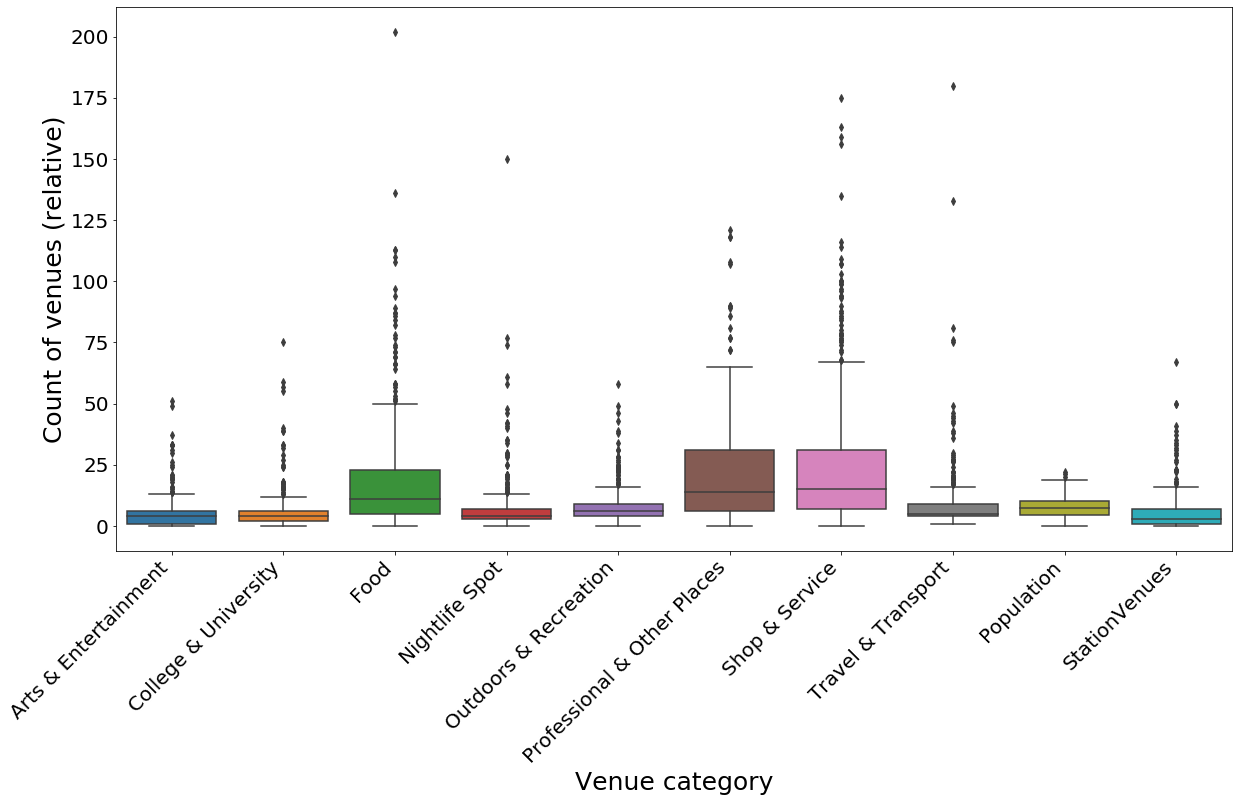

In [152]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation='vertical')
sns.boxplot
ax = sns.boxplot(data = stations_venues_plot_df)
ax.set_ylabel('Count of venues (relative)', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

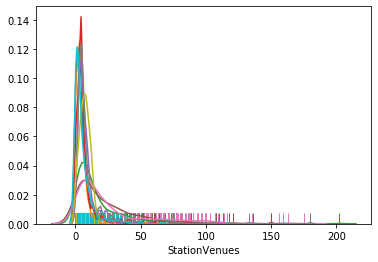

In [153]:
for col in stations_venues_plot_df.columns:
    sns.distplot(stations_venues_plot_df[col], hist=False, rug=True)

## Data preparation¶

In [154]:
stations_venues_df.columns

Index(['Station', 'Code', 'Lat', 'Lon', 'Postcode', 'Arts & Entertainment',
       'College & University', 'Food', 'Nightlife Spot',
       'Outdoors & Recreation', 'Professional & Other Places',
       'Shop & Service', 'Travel & Transport', 'Population', 'StationVenues'],
      dtype='object')

In [155]:
stations_venues_df.shape

(373, 15)

In [156]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer

In [157]:
columns = stations_venues_df.columns[5:]
X = stations_venues_df.values[:,5:]
venue_counts_norm = MinMaxScaler().fit_transform(X)

print("columns: {}".format(columns))
print("X: {}".format(X))
print("venue_counts_norm: {}".format(venue_counts_norm))

columns: Index(['Arts & Entertainment', 'College & University', 'Food',
       'Nightlife Spot', 'Outdoors & Recreation',
       'Professional & Other Places', 'Shop & Service', 'Travel & Transport',
       'Population', 'StationVenues'],
      dtype='object')
X: [[6.0 11.0 36.0 ... 44.0 0.045 18]
 [3.0 8.0 33.0 ... 21.0 8.28 6]
 [3.0 16.0 66.0 ... 27.0 12.66 13]
 ...
 [7.0 3.0 8.0 ... 4.0 2.935 3]
 [4.0 4.0 33.0 ... 22.0 7.58 10]
 [1.0 0.0 4.0 ... 2.0 5.12 0]]
venue_counts_norm: [[0.11764706 0.14666667 0.17821782 ... 0.24022346 0.00158014 0.26865672]
 [0.05882353 0.10666667 0.16336634 ... 0.11173184 0.37336343 0.08955224]
 [0.05882353 0.21333333 0.32673267 ... 0.1452514  0.57110609 0.19402985]
 ...
 [0.1372549  0.04       0.03960396 ... 0.01675978 0.13205418 0.04477612]
 [0.07843137 0.05333333 0.16336634 ... 0.11731844 0.34176072 0.14925373]
 [0.01960784 0.         0.01980198 ... 0.00558659 0.23069977 0.        ]]


In [158]:
venue_counts_norm_df = pd.DataFrame(venue_counts_norm, columns=columns)
venue_counts_norm_df.head(10)

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,Population,StationVenues
0,0.117647,0.146667,0.178218,0.066667,0.327586,0.636364,0.120000,0.240223,0.001580,0.268657
1,0.058824,0.106667,0.163366,0.033333,0.327586,0.371901,0.182857,0.111732,0.373363,0.089552
2,0.058824,0.213333,0.326733,0.106667,0.534483,0.528926,0.285714,0.145251,0.571106,0.194030
3,0.058824,0.040000,0.019802,0.040000,0.103448,0.074380,0.022857,0.016760,0.337246,0.044776
4,0.098039,0.093333,0.039604,0.013333,0.086207,0.066116,0.068571,0.027933,0.327765,0.029851
5,0.588235,0.133333,0.430693,0.273333,0.431034,0.404959,0.611429,0.139665,0.219639,0.238806
6,0.117647,0.226667,0.079208,0.026667,0.068966,0.429752,0.080000,0.044693,0.828217,0.029851
7,0.039216,0.213333,0.069307,0.040000,0.241379,0.198347,0.165714,0.061453,0.437698,0.029851
8,0.156863,0.080000,0.326733,0.140000,0.362069,0.305785,0.565714,0.100559,0.437698,0.149254
9,0.078431,0.066667,0.029703,0.040000,0.137931,0.181818,0.097143,0.039106,0.506321,0.000000


In [159]:
venue_counts_norm_df.shape

(373, 10)

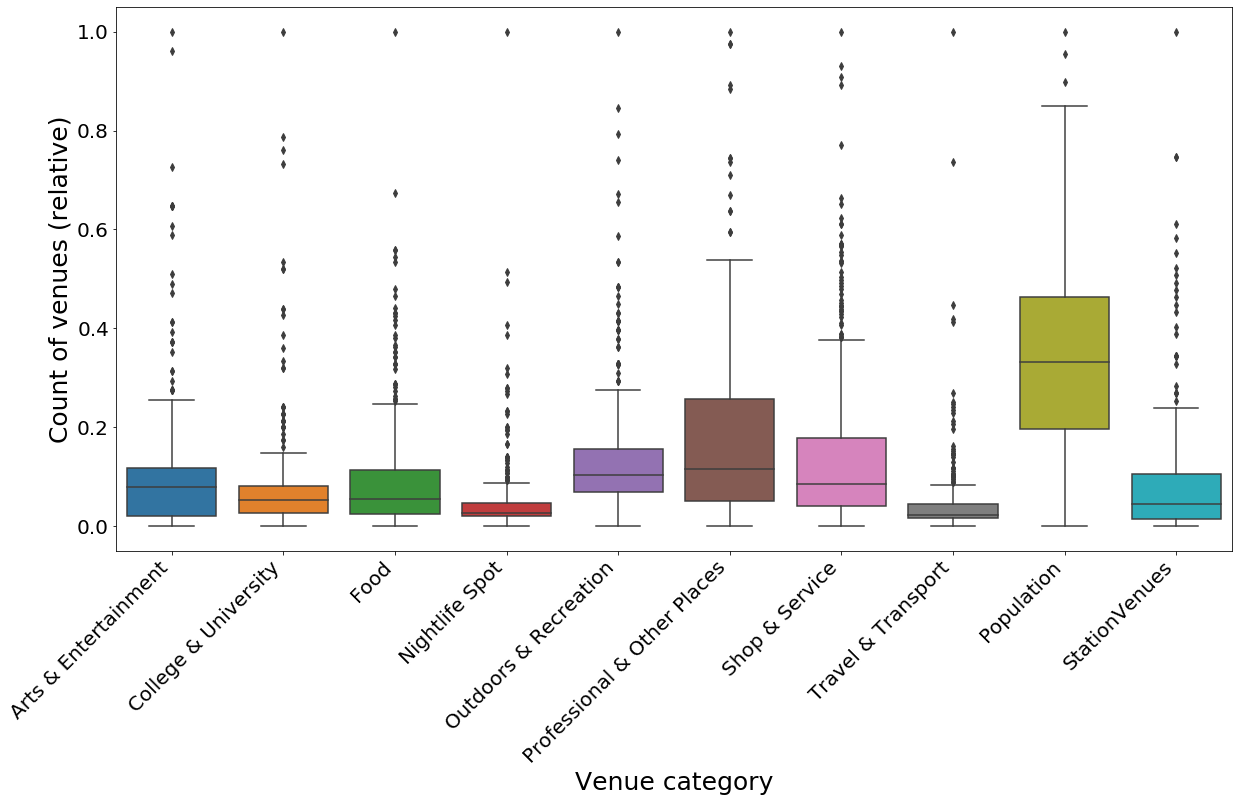

In [160]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = venue_counts_norm_df)
ax.set_ylabel('Count of venues (relative)', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

In [161]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venue_counts_norm_df)

kmeans_labels = kmeans.labels_
# Change label numbers to have a logical grouping
replace_labels = {0:3, 1:1, 2:0, 3:2}
for i in range(len(kmeans_labels)):
    kmeans_labels[i] = replace_labels[kmeans_labels[i]]

In [162]:
stations_venues_df

,Station,Code,Lat,Lon,Postcode,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,Population,StationVenues
0,Amsterdam Sloterdijk,NLAAC,52.389025,4.838111,1043,6.0,11.0,36.0,10.0,19.0,77.0,21.0,44.0,0.045,18
1,Amsterdam Lelylaan,NLAAF,52.357886,4.833913,1062,3.0,8.0,33.0,5.0,19.0,45.0,32.0,21.0,8.280,6
2,Amsterdam Amstel,NLABK,52.346443,4.917593,1097,3.0,16.0,66.0,16.0,31.0,64.0,50.0,27.0,12.660,13
3,Abcoude,NLACD,52.278673,4.976994,1391,3.0,3.0,4.0,6.0,6.0,9.0,4.0,4.0,7.480,3
4,Almelo de Riet,NLADR,52.342218,6.666400,7606,5.0,7.0,8.0,2.0,5.0,8.0,12.0,6.0,7.270,2
5,Arnhem Centraal,NLAHM,51.984780,5.901004,6811,30.0,10.0,87.0,41.0,25.0,49.0,107.0,26.0,4.875,16
6,Amsterdam Holendrecht,NLAHO,52.298108,4.960031,1106,6.0,17.0,16.0,4.0,4.0,52.0,14.0,9.0,18.355,2
7,Arnhem Presikhaaf,NLAHP,51.987890,5.943317,6824,2.0,16.0,14.0,6.0,14.0,24.0,29.0,12.0,9.705,2
8,Arnhem Velperpoort,NLAHV,51.985175,5.919837,6824,8.0,6.0,66.0,21.0,21.0,37.0,99.0,19.0,9.705,10
9,Arnhem Zuid,NLAHZ,51.954837,5.851923,6843,4.0,5.0,6.0,6.0,8.0,22.0,17.0,8.0,11.225,0


In [163]:
stations_venues_df.shape

(373, 15)

In [164]:
venue_counts_norm_df.shape

(373, 10)

In [165]:
venue_counts_norm_df.head(16)

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,Population,StationVenues
0,0.117647,0.146667,0.178218,0.066667,0.327586,0.636364,0.120000,0.240223,0.001580,0.268657
1,0.058824,0.106667,0.163366,0.033333,0.327586,0.371901,0.182857,0.111732,0.373363,0.089552
2,0.058824,0.213333,0.326733,0.106667,0.534483,0.528926,0.285714,0.145251,0.571106,0.194030
3,0.058824,0.040000,0.019802,0.040000,0.103448,0.074380,0.022857,0.016760,0.337246,0.044776
4,0.098039,0.093333,0.039604,0.013333,0.086207,0.066116,0.068571,0.027933,0.327765,0.029851
5,0.588235,0.133333,0.430693,0.273333,0.431034,0.404959,0.611429,0.139665,0.219639,0.238806
6,0.117647,0.226667,0.079208,0.026667,0.068966,0.429752,0.080000,0.044693,0.828217,0.029851
7,0.039216,0.213333,0.069307,0.040000,0.241379,0.198347,0.165714,0.061453,0.437698,0.029851
8,0.156863,0.080000,0.326733,0.140000,0.362069,0.305785,0.565714,0.100559,0.437698,0.149254
9,0.078431,0.066667,0.029703,0.040000,0.137931,0.181818,0.097143,0.039106,0.506321,0.000000


In [166]:
stations_clusters_df = venue_counts_norm_df.copy()
stations_clusters_df['Cluster'] = kmeans_labels

stations_clusters_counts_df = stations_venues_df.copy()
stations_clusters_counts_df['Cluster'] = kmeans_labels
stations_clusters_counts_df['Station'] = stations_venues_df['Station']
stations_clusters_counts_df['Lat'] = stations_venues_df['Lat']
stations_clusters_counts_df['Lon'] = stations_venues_df['Lon']

stations_clusters_counts_df.shape

(373, 16)

In [167]:
stations_clusters_counts_df

,Station,Code,Lat,Lon,Postcode,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,Population,StationVenues,Cluster
0,Amsterdam Sloterdijk,NLAAC,52.389025,4.838111,1043,6.0,11.0,36.0,10.0,19.0,77.0,21.0,44.0,0.045,18,1
1,Amsterdam Lelylaan,NLAAF,52.357886,4.833913,1062,3.0,8.0,33.0,5.0,19.0,45.0,32.0,21.0,8.280,6,1
2,Amsterdam Amstel,NLABK,52.346443,4.917593,1097,3.0,16.0,66.0,16.0,31.0,64.0,50.0,27.0,12.660,13,1
3,Abcoude,NLACD,52.278673,4.976994,1391,3.0,3.0,4.0,6.0,6.0,9.0,4.0,4.0,7.480,3,3
4,Almelo de Riet,NLADR,52.342218,6.666400,7606,5.0,7.0,8.0,2.0,5.0,8.0,12.0,6.0,7.270,2,3
5,Arnhem Centraal,NLAHM,51.984780,5.901004,6811,30.0,10.0,87.0,41.0,25.0,49.0,107.0,26.0,4.875,16,0
6,Amsterdam Holendrecht,NLAHO,52.298108,4.960031,1106,6.0,17.0,16.0,4.0,4.0,52.0,14.0,9.0,18.355,2,2
7,Arnhem Presikhaaf,NLAHP,51.987890,5.943317,6824,2.0,16.0,14.0,6.0,14.0,24.0,29.0,12.0,9.705,2,2
8,Arnhem Velperpoort,NLAHV,51.985175,5.919837,6824,8.0,6.0,66.0,21.0,21.0,37.0,99.0,19.0,9.705,10,1
9,Arnhem Zuid,NLAHZ,51.954837,5.851923,6843,4.0,5.0,6.0,6.0,8.0,22.0,17.0,8.0,11.225,0,2


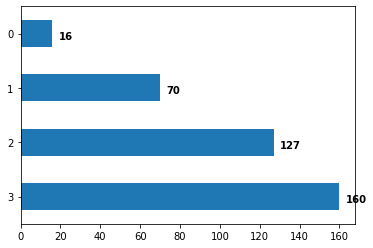

In [168]:
# pd.DataFrame(kmeans_labels, columns=['Category'])['Category'].value_counts().plot(kind='barh')
label_counts = pd.Series(kmeans_labels).value_counts().sort_index(ascending =False)
ax = label_counts.plot(kind='barh')
for i, v in enumerate(label_counts):
    ax.text(v + 3, i - .1, str(v), color='black', fontweight='bold')

In [169]:
for c in range(kclusters):
    stations = stations_clusters_counts_df[stations_clusters_counts_df['Cluster']==c]
    print("c: {} - #stations: {}".format(c, len(stations)))
    print("        stations:\n{}".format(stations['Station']))

c: 0 - #stations: 16
        stations:
5              Arnhem Centraal
20       Amsterdam Muiderpoort
31     Amsterdam Bijlmer ArenA
32          Amsterdam Centraal
35              Amsterdam Zuid
38                       Breda
83                       Delft
85           Den Haag Centraal
120                  Eindhoven
142                  Groningen
168                    Haarlem
206            Leiden Centraal
272         Rotterdam Centraal
284           Schiphol Airport
300                    Tilburg
311           Utrecht Centraal
Name: Station, dtype: object
c: 1 - #stations: 70
        stations:
0        Amsterdam Sloterdijk
1          Amsterdam Lelylaan
2            Amsterdam Amstel
8          Arnhem Velperpoort
13              Almere Buiten
14             Almere Centrum
15                 Amersfoort
16                     Almelo
21                    Alkmaar
26                  Apeldoorn
30            Alphen a/d Rijn
33                      Assen
46             Bergen op Zoom
62     

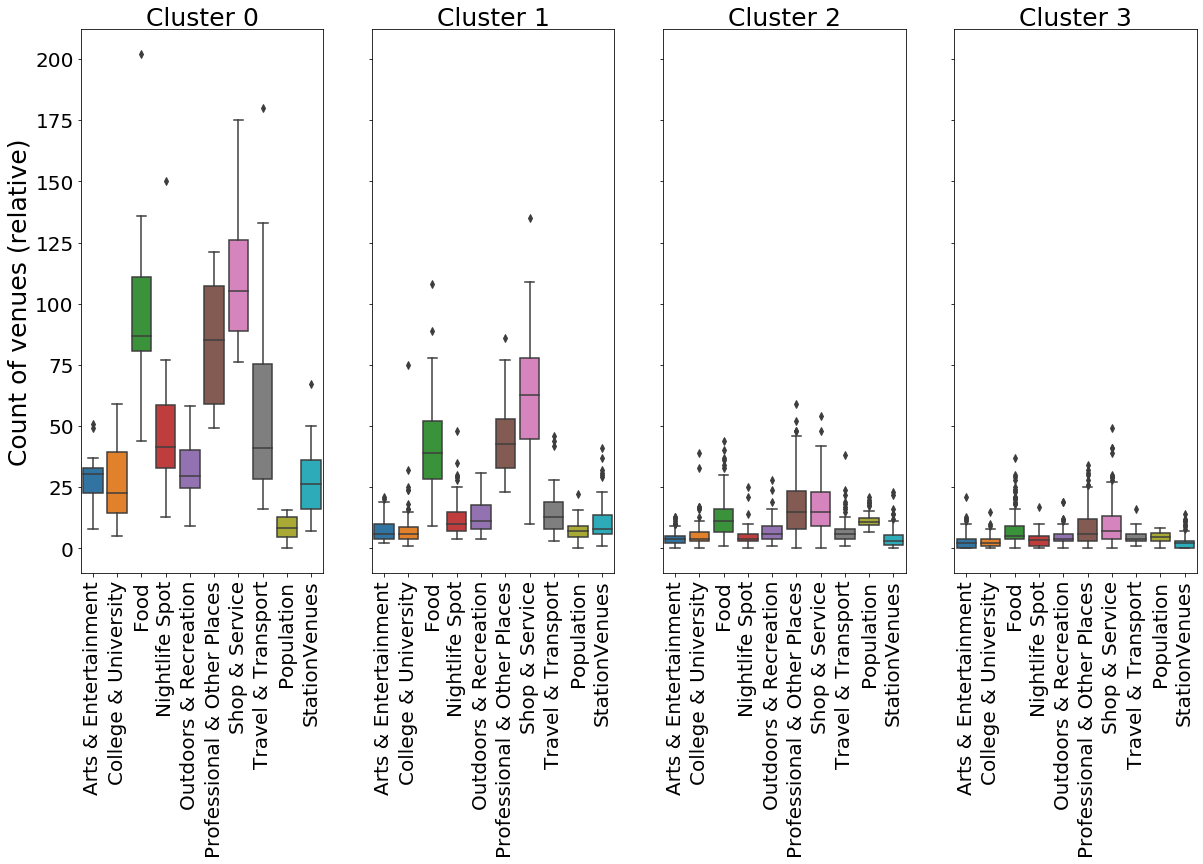

In [171]:
import matplotlib.ticker as ticker

stations_clusters_plot_df = stations_clusters_counts_df.copy().drop(['Lat', 'Lon', 'Postcode'], axis=1)

fig, axes = plt.subplots(1,kclusters, figsize=(20, 10), sharey=True)

axes[0].set_ylabel('Count of venues (relative)', fontsize=25)
#plt.set_xlabel('Venue category', fontsize='x-large')

for k in range(kclusters):
    #Set same y axis limits
    #axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data = stations_clusters_plot_df[stations_clusters_plot_df['Cluster'] == k].drop('Cluster',1), ax=axes[k])

plt.show()

In [172]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
location = 'Netherlands'

geolocator = Nominatim(user_agent="nl_explorer")
location = geolocator.geocode(location)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(location, latitude, longitude))

The geograpical coordinate of Nederland are 52.24726925, 5.54122345487672.


In [173]:
stations_clusters_counts_df.head(10)

,Station,Code,Lat,Lon,Postcode,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,Population,StationVenues,Cluster
0,Amsterdam Sloterdijk,NLAAC,52.389025,4.838111,1043,6.0,11.0,36.0,10.0,19.0,77.0,21.0,44.0,0.045,18,1
1,Amsterdam Lelylaan,NLAAF,52.357886,4.833913,1062,3.0,8.0,33.0,5.0,19.0,45.0,32.0,21.0,8.280,6,1
2,Amsterdam Amstel,NLABK,52.346443,4.917593,1097,3.0,16.0,66.0,16.0,31.0,64.0,50.0,27.0,12.660,13,1
3,Abcoude,NLACD,52.278673,4.976994,1391,3.0,3.0,4.0,6.0,6.0,9.0,4.0,4.0,7.480,3,3
4,Almelo de Riet,NLADR,52.342218,6.666400,7606,5.0,7.0,8.0,2.0,5.0,8.0,12.0,6.0,7.270,2,3
5,Arnhem Centraal,NLAHM,51.984780,5.901004,6811,30.0,10.0,87.0,41.0,25.0,49.0,107.0,26.0,4.875,16,0
6,Amsterdam Holendrecht,NLAHO,52.298108,4.960031,1106,6.0,17.0,16.0,4.0,4.0,52.0,14.0,9.0,18.355,2,2
7,Arnhem Presikhaaf,NLAHP,51.987890,5.943317,6824,2.0,16.0,14.0,6.0,14.0,24.0,29.0,12.0,9.705,2,2
8,Arnhem Velperpoort,NLAHV,51.985175,5.919837,6824,8.0,6.0,66.0,21.0,21.0,37.0,99.0,19.0,9.705,10,1
9,Arnhem Zuid,NLAHZ,51.954837,5.851923,6843,4.0,5.0,6.0,6.0,8.0,22.0,17.0,8.0,11.225,0,2


In [177]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=7)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
cluster_colors = ['red', 'blue','green','orange']
radius = [5, 4, 3, 2]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(stations_clusters_counts_df['Lat'], 
                                  stations_clusters_counts_df['Lon'], 
                                  stations_clusters_counts_df['Station'], 
                                  stations_clusters_counts_df['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = radius[cluster],
        popup = label,
        color = cluster_colors[cluster],
        fill = True,
        fill_color = cluster_colors[cluster],
        fill_opacity = 0.7).add_to(map_clusters)
       
map_clusters